In [290]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

#### Need to test if add features are benefitials 

In [291]:
df = pd.read_csv('num_data.csv')

In [292]:
dataset =df

In [293]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real PM2.5 Concentration')
    plt.plot(predicted, color='blue',label='Predicted PM2.5 Concentation')
    plt.title('PM2.5 Concentration Prediction')
    plt.xlabel('Time')
    plt.ylabel('PM2.5  Concentration')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [294]:
from sklearn.model_selection import train_test_split

In [295]:
train_size=int(dataset.shape[0] * 0.6)
test_size = int(dataset.shape[0] - train_size)

In [296]:
training_set = dataset[:train_size].iloc[:,4:5].values
test_set = dataset[train_size:].iloc[:,4:5].values

In [297]:
training_set.shape

(12000, 1)

In [298]:
# # Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [299]:
# Since LSTMs store long term memory state, we create a data structure with 24 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
seq_len = 60
for i in range(seq_len, train_size):
    X_train.append(training_set_scaled[i-seq_len:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [300]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [301]:
GRU_reg = Sequential()
LSTM_reg = Sequential()
GRU_GRU_reg =  Sequential()
GRU_LSTM_reg = Sequential()
LSTM_GRU_reg = Sequential()
LSTM_LSTM_reg = Sequential()

GRU_reg.add(GRU(units=0))
GRU_reg.add(Dropout(0.2))
# The output layer
GRU_reg.add(Dense(units=1))


LSTM_reg.add(LSTM(units=50, return_sequences=True))
# The output layer
LSTM_reg.add(Dense(units=1))


LSTM_GRU_reg.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
LSTM_GRU_reg.add(GRU(units=100, activation='tanh'))
# The output layer
LSTM_GRU_reg.add(Dense(units=1))


GRU_LSTM_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
GRU_LSTM_reg.add(LSTM(units=50, activation='tanh'))
# The output layer
GRU_LSTM_reg.add(Dense(units=1))

# Compiling the RNNs
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

GRU_reg.compile(optimizer='rmsprop',loss='mean_squared_error')
LSTM_reg.compile(optimizer='rmsprop',loss='mean_squared_error')

LSTM_GRU_reg.compile(optimizer=sgd,loss='mean_squared_error')

GRU_LSTM_reg.compile(optimizer='rmsprop',loss='mean_squared_error')

In [302]:
# Fitting to the training set
# LSTM_reg.fit(X_train,y_train,epochs=50,batch_size=32)
# GRU_reg.fit(X_train,y_train,epochs=50,batch_size=32)
# LSTM_GRU_reg.fit(X_train,y_train,epochs=50,batch_size=32)

# LSTM_GRU_reg.fit(X_train,y_train,epochs=50,batch_size=32)
LSTM_GRU_reg.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/25
11940/11940 [==============================] - 20s 2ms/step - loss: 0.0053
Epoch 2/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0032
Epoch 3/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0029
Epoch 4/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0028
Epoch 5/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0026
Epoch 6/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0025
Epoch 7/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0024
Epoch 8/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0023
Epoch 9/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0023
Epoch 10/25
11940/11940 [==============================] - 17s 1ms/step - loss: 0.0022
Epoch 11/25
11940/11940 [==============================] - 18s 2ms/step - loss: 0.0022
Epoch 12/25
11940/11940 [===========================

In [303]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
inputs = dataset[len(dataset)-len(test_set) - seq_len:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)


In [304]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(seq_len,test_size+seq_len):
    X_test.append(inputs[i-seq_len:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_PM25 = LSTM_GRU_reg.predict(X_test)
predicted_PM25 = sc.inverse_transform(predicted_PM25)

In [305]:
y_train_pred = LSTM_GRU_reg.predict(X_train)
y_train_pred = sc.inverse_transform(y_train_pred)

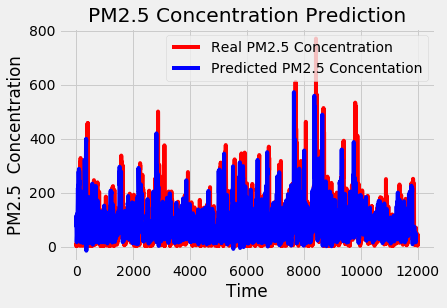

In [306]:
plot_predictions(training_set,y_train_pred)

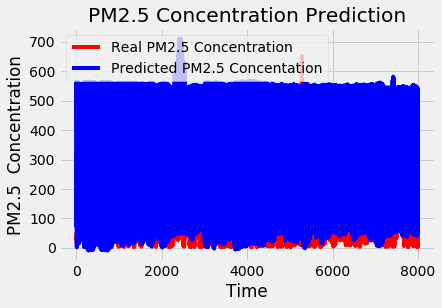

In [307]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_PM25)

In [308]:
# Evaluating our model
return_rmse(test_set,predicted_PM25)

The root mean squared error is 248.85845687946411.


Truth be told. That's one awesome score. 

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units(GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)

<img src="https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/11/GRU.png?x31195">

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

## Sequence Generation
Here, I will generate a sequence using just initial 60 values instead of using last 60 values for every new prediction. **Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation.** The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. You can try this using LSTMs also. I have modified GRU model above to get the best sequence possible. I have run the model four times and two times I got error of around 8 to 9. The worst case had an error of around 11. Let's see what this iterations.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. **The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you. I can't give you some 100 lines of code where you put the destination of training and test set and get world-class results. That's something you have to do yourself.**

In [ ]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

In [ ]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [ ]:
# Evaluating the sequence
return_rmse(test_set,sequence)